In [1]:
# will find and plot incongruent trials
import pickle
import json
import sys

# make sure dynamics path is pulled form appropriate place
sys.path.insert(0, '/Users/dhocker/projects/kind_cl/')

from dynamics.process.rnn import wt_protocols
from dynamics.process.rnn import parse
from dynamics.analysis import KEmin, flowfields, posttraining



import dynamics.analysis.dynamics_analysis as dyn
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt



%load_ext autoreload
%autoreload 2

In [2]:
import dynamics
print(dynamics.__file__)

/Users/dhocker/projects/kind_cl/dynamics/__init__.py


In [3]:
num = 33
stype = 'full_cl/'
reg_idx = 0
s_idx = 0
t_idx = 5
epoch = 'wait'

# cluster
#basedirectory = '/home/dh148/projects/dynamics/dynamics/analysis/'
#datadir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/'+stype+str(num)+'/'

#local
basedirectory = '/Users/dhocker/projects/kind_cl/dynamics/analysis/'
datadir = '/Users/dhocker/projects/dynamics/results/20231003/'+stype+str(num)+'/'


In [5]:
# load raw data

# load data
dataname = datadir + 'rnn_curric_33_block_10_1k.json'
modelname = datadir+'rnn_curric_33_block_10.model'

with open(dataname,'r') as f:
    jsondat = json.load(f)

dat = parse.json2dat(jsondat)


fo = {'reg_idx': 0, 's_idx': 0, 'tphase': 5, 'epoch': 'wait', 'blocktype': 'mixed',
      'verbose': True, 'useKEbounds': False,
      'basedirectory': basedirectory,
      'savedir': None} 

dynops = {'numhidden': [256, 256], 'resim': False, 'configname': basedirectory+'block.cfg', 'epoch': 'wait',
              'zeromean': False, 'block_idx': None, 'drtype':'PCA'}

rd = dyn.dynamics_preprocess_suite(modelname, dat, simtype='task', dynops=dynops)

uniqueops: adam_fname not defined in config. using default
postprocessing simulation data for dynamics. finding outliers and repackaging state
epoch wait
dim, layer 0: 3
dim, layer 1: 3


In [7]:
rd.keys()

dict_keys(['behdict', 'inp', 'dat2fit', 'tdict', 'statedict', 'dr_list', 'D', 'net'])

In [8]:
# find incongruent trials
reg_idx = 0

#flatten state, pred, and get trial times
sflat, inp, tdict = parse.get_trialtimes(dat)
predflat = []
for j in dat['preds']:
    predflat.extend(j)
    
sflat_ofc = []
sflat_str = []
for sj in sflat:
    sflat_ofc_j = np.squeeze(np.concatenate((np.expand_dims(sj[0,0,:],axis=1),
                                             np.expand_dims(sj[0,1,:],axis=1)),axis=0))
    sflat_str_j = np.squeeze(np.concatenate((np.expand_dims(sj[1,0,:],axis=1),
                                             np.expand_dims(sj[1,1,:],axis=1)),axis=0))
    
    sflat_ofc.append(sflat_ofc_j)
    sflat_str.append(sflat_str_j)   
    
if reg_idx == 0:    
    pca_use = rd['dr_list'][0]
    sflat_use = np.array(sflat_ofc)
else:
    pca_use = rd['dr_list'][1]
    sflat_use = np.array(sflat_str)
    
    
# find incongruent trials at block transitions
blocks = dat['blocks']
preds_start = np.array([predflat[j] for j in tdict['start']])
offers = dat['rewvols']
pblock = np.array([softmax(j) for j in predflat])
outcomes = dat['outcomes']

#find block transitions
test = np.argwhere(np.diff(blocks)!= 0)


#the located transition points in this data. can examine them with pblock, outcomes, blocks, offers, etc.
idx_h2m = 165
idx_m2h = 123
idx_m2l = 373  # 39, 207, 373
idx_l2m = 80

print(blocks[idx_m2l:idx_m2l+2])
print(blocks[idx_l2m:idx_l2m+2])
print(blocks[idx_m2h:idx_m2h+2])
print(blocks[idx_h2m:idx_h2m+2])

[0 2]
[2 0]
[0 1]
[1 0]


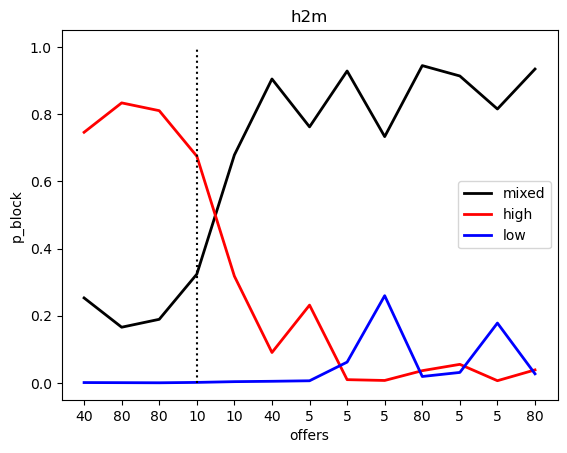

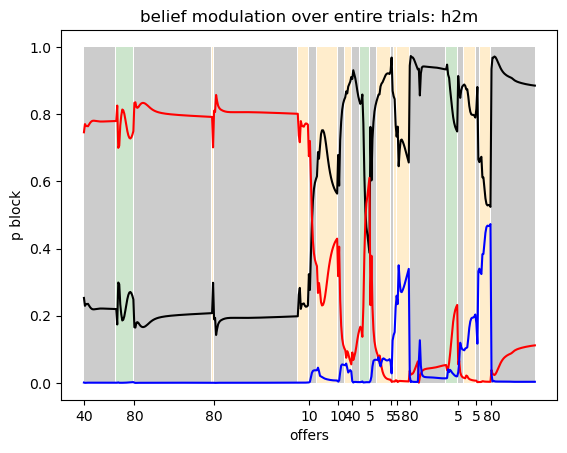

In [10]:
#Fig 4B and supp:  set transition type and make figure 

transtype = 'h2m'

if transtype == 'm2h':
    trans_idx = [idx_m2h-1, idx_m2h+1, idx_m2h+6]
elif transtype == 'h2m':
    trans_idx = [163, 167, 175] #pre-incongruent, incongruent, congruent
elif transtype == 'l2m':
    trans_idx = [idx_l2m-1, idx_l2m+2, idx_l2m+4]
elif transtype == 'm2l':
    trans_idx = [idx_m2l-2, idx_m2l+1, idx_m2l+7]
else:
    print('issue with transtype')
    
    
    
#show the change in beliefs at a block transition you found:
#trying to figure out the predicted pblock values on my trials of interest


idx_precon = trans_idx[0]
idx_incon = trans_idx[1]
idx_con = trans_idx[2]


tdict = rd['behdict']['tdict']
preds = rd['behdict']['preds']
preds_flat = []
for k in preds:
    preds_flat.extend(k)
    
offers = rd['behdict']['offers'][idx_precon:idx_con+1]

logpvals = np.array([preds[tdict['start'][k]] for k in range(idx_precon, idx_con+1)])
pvals = softmax(logpvals,axis=1)

tvec = range(-3,len(range(idx_precon,idx_con))-2)
plt.plot(tvec,pvals[:,0],linewidth=2, color='k',label='mixed')
plt.plot(tvec,pvals[:,1],linewidth=2, color='red',label='high')
plt.plot(tvec,pvals[:,2],linewidth=2, color='blue',label='low')

plt.vlines(0,0,1,color='k',linestyle='dotted')
plt.xticks(tvec,np.exp(offers).astype(int))

plt.legend()
plt.title(transtype)
plt.xlabel('offers')
plt.ylabel('p_block')
plt.show()

#---------=

tstarts = np.array(tdict['start'][idx_precon:idx_con+1])-tdict['start'][idx_precon]
titi = np.array(tdict['iti'][idx_precon:idx_con+1])-tdict['start'][idx_precon]
outcomes_testdat = outcomes[idx_precon:idx_con+1]

for j in range(len(tstarts)):
    plt.fill_between(range(tstarts[j],titi[j]),0,1,color = 'k',alpha = 0.2, linewidth=0.0)
    

for j in range(len(tstarts)-1):
    if outcomes_testdat[j] == 1:
        plt.fill_between(range(titi[j],tstarts[j+1]),0,1,color = 'g',alpha = 0.2, linewidth=0)
    elif outcomes_testdat[j] == 0:
        plt.fill_between(range(titi[j],tstarts[j+1]),0,1,color = 'orange',alpha = 0.2, linewidth=0)

#[plt.vlines(k,0,1,linestyle='dotted',color='k') for k in tstarts]
#[plt.vlines(k,0,1,linestyle='dotted',color='r') for k in titi]



plt.plot(pblock[tdict['start'][idx_precon]:tdict['iti'][idx_con],0],color='k')
plt.plot(pblock[tdict['start'][idx_precon]:tdict['iti'][idx_con],1],color='r')
plt.plot(pblock[tdict['start'][idx_precon]:tdict['iti'][idx_con],2],color='b')

plt.ylabel('p block')
plt.xlabel('timesteps')


plt.xticks(tstarts,np.exp(offers).astype(int))
plt.xlabel('offers')
#plt.xlim([200,420])

pmixdat = pblock[tdict['start'][idx_precon]:tdict['iti'][idx_con],0]


plt.title('belief modulation over entire trials: ' + transtype)

#plt.savefig('/Users/dhocker/Desktop/belief_m2.pdf')
#plt.savefig('/Users/dhocker/projects/dynamics/writings/natml2023/base/belief'+transtype+'.pdf')

plt.show()


In [ ]:
# TODO delete

In [11]:
#supp, if needed: all data projected into PC space, by block, or belief

#create groups of trials, and flattened analogs, that are useful

case = 'block'  #options: block, belief, block20, belief20

if case == 'block':
    maskvec = [blocks==0, blocks==1, blocks==2]
if case == 'block20':
    maskvec = [(blocks==0) & (offers == 20), (blocks==1) & (offers == 20), (blocks==2) & (offers == 20)]

#grab all data from tstart to iti, separate by block
samps_mixed = []
samps_high = []
samps_low = []
samps_all = []


samps_mixed_flat = []
samps_high_flat = []
samps_low_flat = []

blocks = dat['blocks']
preds_start = np.array([predflat[j] for j in tdict['start']])
offers = dat['rewvols']
pblock = np.array([softmax(j) for j in predflat])

for j in range(len(tdict['start'])):
    sj = sflat_use[tdict['start'][j]+1:tdict['iti'][j],:]
    samps_all.append(sj)
    if maskvec[0][j]:
        samps_mixed.append(sj)
    elif maskvec[1][j]:
        samps_high.append(sj)
    elif maskvec[2][j]:
        samps_low.append(sj)
    else:
        print('ignoring trial')
        
        
for j in samps_mixed:
    samps_mixed_flat.extend(j)
for j in samps_high:
    samps_high_flat.extend(j)
for j in samps_low:
    samps_low_flat.extend(j)

    
#plot the true block samples

samps2check = [samps_mixed_flat,samps_high_flat,samps_low_flat]
colors = ['k','r','b']

dat_pca = [pca_use.transform(k)[:,:d] for k in samps2check]
plt.scatter(dat_pca[0][:,0],dat_pca[0][:,1],10,color='k')
plt.scatter(dat_pca[1][:,0],dat_pca[1][:,1],10,color='r')
plt.scatter(dat_pca[2][:,0],dat_pca[2][:,1],10,color='b')
if case == 'block':
    plt.title('PCA of high/mixed/low trials. ALL trials, not just 20uL')
elif case == 'block20':
    plt.title('PCA of high/mixed/low 20ul trials')

NameError: name 'd' is not defined